In [1]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [2]:
DIR = '../../data/processed'
crawls = glob.glob('{}/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [3]:
df.columns

Index(['claim', 'descriptions', 'img', 'label', 'legal_page_urls', 'page_urls',
       'text_on_image', 'url_caption', 'known_urls', 'true_perc', 'false_perc',
       'mixed_perc', 'invalid_count', 'known_count', 'total_count'],
      dtype='object')

In [4]:
df = df[['legal_page_urls', 'label']][df.label!='mixture']

In [5]:
df.shape

(969, 2)

In [6]:
df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [7]:
df_labels = pd.read_csv('{}/known_articles_labeled.csv'.format(DIR)).set_index('url')

In [8]:
df_labels = df_labels[~df_labels.index.duplicated(keep='first')]

In [9]:
def get_title(url):
    if url in df_labels.index and df_labels.loc[url]['media_label'] == 'FALSE':
        return str(df_labels.loc[url].title)
    return ''

In [10]:
df['media_titles'] = df.legal_page_urls.map(lambda x: ' '.join([get_title(y) for y in x]).strip())

In [11]:
df = df.replace('',np.nan).dropna()

In [12]:
df.media_titles.iloc[0]

'New Photo Show Manafort, Mueller Worked With Former Ukraine President'

In [13]:
df.label.value_counts(normalize=True)

false    0.688889
true     0.311111
Name: label, dtype: float64

In [14]:
X = list(df.media_titles)
y = df.label.apply(lambda x: True if x=='true' else False).ravel()

In [26]:
len(X)

45

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [16]:
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

In [17]:
sm = SMOTE(ratio = 'auto', k_neighbors = 5, n_jobs = -1)
#smote_enn = SMOTEENN(smote = sm)

clf = SVC()
# SVC
parameters = {
    #'smote_enn__smote__k_neighbors': [1,2,3,4,5,10],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'], 
              'clf__C': [0.001, 0.01, 0.1, 0.25,0.5,0.75, 1,10, 25, 50, 100, 1000],
              'clf__gamma': [0.0001,0.001,0.01,0.1,1,2,3,'auto','scale'],
             'clf__class_weight': ['balanced'],
             'clf__probability': [True]}

steps = [('vectorizer', CountVectorizer(stop_words='english')), 
         ('scaler', MaxAbsScaler()),
         #('smote_enn', smote_enn), 
         ('clf', clf)]

pipeline = Pipeline(steps)

rs_clf = RandomizedSearchCV(pipeline, param_distributions = parameters, n_iter=100, verbose=2,

                            scoring='f1', refit=True,cv=folds, random_state=42, n_jobs=-1)

In [18]:
rs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.8s finished
/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
  ...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'clf__kernel': ['linear', 'rbf', 'sigmoid'], 'clf__C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 25, 50, 100, 1000], 'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 'auto', 'scale'], 'clf__class_weight': ['balanced'], 'clf__probability': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

In [19]:
best_score = rs_clf.best_score_

best_params = rs_clf.best_params_

print("Best score: {}".format(best_score))

print("Best params: {}".format(best_params))

Best score: 0.5272727272727272
Best params: {'clf__probability': True, 'clf__kernel': 'sigmoid', 'clf__gamma': 2, 'clf__class_weight': 'balanced', 'clf__C': 1}


In [20]:
pd.Series(y_test).value_counts(normalize=True)

False    0.666667
True     0.333333
dtype: float64

In [21]:
pred = rs_clf.predict(X_test)
pd.Series(pred).value_counts(normalize=True)

False    0.75
True     0.25
dtype: float64

In [25]:
len(X_test)

12

In [22]:
y_pred = rs_clf.predict_proba(X_test)
y_pred = y_pred[:,1]

In [23]:
y_pred

array([0.29537894, 0.30945785, 0.24610587, 0.27069292, 0.40562769,
       0.14242521, 0.25126303, 0.29537894, 0.41189758, 0.31005329,
       0.29537894, 0.3599982 ])

In [27]:
roc_auc_score(y_test, y_pred)

0.5625

In [28]:
pred_all_true = np.array([True] * len(pred))

In [29]:
f1_score(y_test, pred_all_true)

0.5

In [30]:
f1_score(y_test, pred)

0.28571428571428575

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.46')

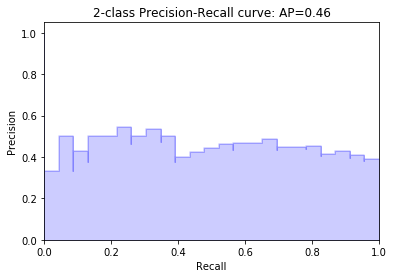

In [75]:
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))